In [53]:
# loading latent data
import numpy as np
import matplotlib.pyplot as plt

SFH_data = np.load('Latent data/SFHdata.npy')
mass_sfr = np.load('Latent data/masspresentsfr.npy')

In [54]:
mass_sfr.shape, SFH_data.shape

((63110, 2), (63110, 139))

In [55]:
from sklearn.model_selection import train_test_split
import torch

X_train, X_test, y_train, y_test = train_test_split(SFH_data, mass_sfr, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32) 
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

In [46]:
device = torch.device("mps")

In [56]:
# Building an MLP model
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(139, 10)
        self.fc2 = nn.Linear(10, 2)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = MLP().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [57]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=200, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=200, shuffle=False)

In [58]:
# Training loop
num_epochs = 300
losses = [] # To store training losses
val_losses = []  # To store validation losses

for epoch in range(num_epochs):
    loss = 0.0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        curr_loss = criterion(outputs, targets)
        curr_loss.backward()
        optimizer.step()
        loss += curr_loss.item()

    loss /= len(dataloader)
    losses.append(loss)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_dataloader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_targets).item()
    
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)


    if (epoch + 1) % 10 == 0:  
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')

print('Training complete')

Epoch [10/300], Training Loss: 0.3345, Val Loss: 0.3106
Epoch [20/300], Training Loss: 0.3279, Val Loss: 0.3147
Epoch [30/300], Training Loss: 0.3211, Val Loss: 0.3209
Epoch [40/300], Training Loss: 0.3191, Val Loss: 0.3502
Epoch [50/300], Training Loss: 0.3135, Val Loss: 0.3614
Epoch [60/300], Training Loss: 0.3088, Val Loss: 0.3157
Epoch [70/300], Training Loss: 0.3051, Val Loss: 0.2912


KeyboardInterrupt: 

(0.0, 1.0)

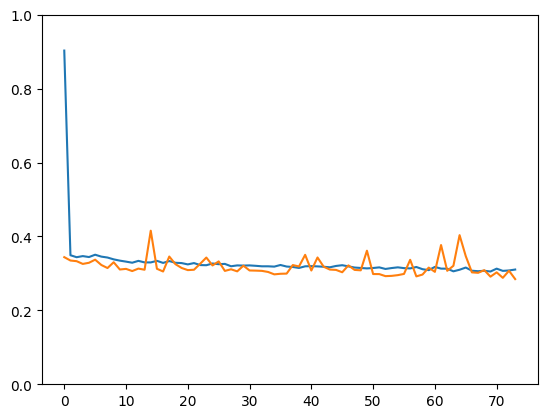

In [59]:
plt.plot(losses)
plt.plot(val_losses)
plt.ylim(0, 1)

In [52]:
# test model accuracy
test_outputs = model(torch.tensor(X_test).to(device))


In [36]:
test_outputs_categorical = np.zeros(test_outputs.shape)
for i in range(len(test_outputs)):
    _, indices = torch.max(test_outputs[i], 0)    
    predicted_label = indices.item()
    test_outputs_categorical[i][predicted_label] = 1

Text(0.5, 1.0, 'Confusion Matrix: SFH, 0,695 Accuracy')

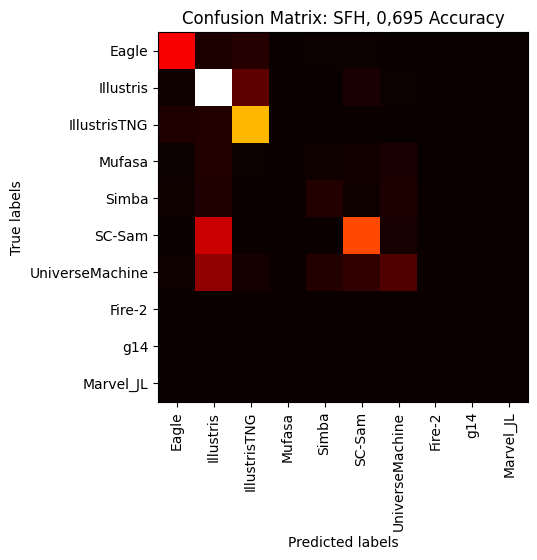

In [39]:
confusion_matrix = np.zeros((10, 10))
for i in range(len(y_test)):
    true_label = np.argmax(y_test[i])
    predicted_label = np.argmax(test_outputs_categorical[i])
    confusion_matrix[true_label][predicted_label] += 1

plt.imshow(confusion_matrix, cmap='hot', interpolation='nearest')
# Labelling the simulation names

sim_names = ['Eagle', 'Illustris', 'IllustrisTNG', 'Mufasa', 'Simba', 'SC-Sam', 'UniverseMachine', 'Fire-2', 'g14', 'Marvel_JL']
plt.xticks(np.arange(10), sim_names, rotation=90)
plt.yticks(np.arange(10), sim_names)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix: SFH, 0,695 Accuracy')

In [37]:
# Printing the confusion matrix without scientific notation
np.set_printoptions(suppress=True)
print(confusion_matrix)

[[ 618.   17.   73.    5.    0.    8.   10.    0.    0.    0.]
 [  27. 1735.   58.   12.    0.   90.   46.    0.    0.    0.]
 [  21.   74. 1078.    7.    1.    5.    7.    0.    0.    0.]
 [   9.   17.    6.   48.   40.   14.   35.    0.    0.    0.]
 [   8.    7.    9.   25.  107.   11.   33.    0.    0.    0.]
 [   6.   75.    6.    8.    7. 1160.   62.    0.    0.    0.]
 [   7.   65.   13.   44.   41.  100.  454.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    1.    0.    0.    0.    1.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]]


In [38]:
# calculate accuracy
correct = 0
for i in range(len(y_test)):
    if np.array_equal(y_test[i], test_outputs_categorical[i]):
        correct += 1

print(correct / len(y_test))

0.6952939312311837
